## Joint MCMC Sampling
This notebook attemps to sample from the joint posterior of planck and LSST. The emulator is used to compute the LSST likelihood and the Planck likelihood is assummed to be the posterior (for now). For parameters in planck but not LSST the joint prior is extended to be uninformative in the new parameters. Since the experiments are independent the joint likelihood is simply the sum/product.

In [147]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples, WeightedSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib inline

In [148]:
# Find the planck posterior
#
### Functions
class Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self._loss = []
        self._epoch = []
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_epoch_end(self, epoch, logs=None):
        self._loss.append(logs['loss'])
        self._epoch.append(epoch)
        #print(logs['loss'],epoch)

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!                          ')
        fig,ax1 = plt.subplots(1,1)
        
        ax1.set_title('loss vs. epoch')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(self._epoch,self._loss)
        
class No_Plot_Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!                             ')

def pregauss(chain,data):
    covmat = chain.cov().astype(np.float32)
    mean = chain.getMeans().astype(np.float32)
    
    # bijector time!
    # TriL means the cov matrix is lower triangular. Inverse is easy to compute that way
    # the cholesky factorization takes a positive definite hermitian matrix M (like the covmat) to LL^T with L lower triangluar
    gauss_approx = tfd.MultivariateNormalTriL(loc=mean,scale_tril=tf.linalg.cholesky(covmat))
    bijector = gauss_approx.bijector

    # now map the data
    new_data = bijector.inverse(data.astype(np.float32))
    return new_data,bijector

def train(base,data,bijectors,batch_size,n_epochs,feedback=True):
    val_split = 0.1
    # stack data
    _data = []
    dim = 0
    for key in data.getParamNames().list():
        nsamples=len(data[key])
        _data.append(data[key])
        dim += 1

    xdata = np.stack(_data, axis=-1)

    x_data,bij = pregauss(data,xdata)

    #create data set with weights.
    weights = data.weights.astype(np.float32)
    
    ## NN setup
    target_distribution = tfd.TransformedDistribution(
        distribution=base,
        bijector=tfb.Chain(bijectors)) 

    # Construct model.
    x_ = tfk.Input(shape=(dim,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=lambda _, log_prob: -log_prob) 
    if(feedback):
        print('---   Model compiled   ---')
        print(" - N samples = {}".format(nsamples))
        if weights.all()==weights[0]:
            print(" - Uniform weights = {}".format(weights[0]))
        else:
            print(" - Non-uniform weights")
        print(" - Pre-Gaussian Map = True\n")
        print(" - Validation split = {}".format(val_split))
        print(' - Number MAFS = {} '.format(int(len(bijectors)/2)))
        print(' - Trainable parameters = {} \n'.format(model.count_params()))

    # now perform the fit
    if(feedback):
        model.fit(x=x_data,
                  y=np.zeros((nsamples, dim),dtype=np.float32),
                  batch_size=batch_size,
                  epochs=n_epochs,
                  steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
                  validation_split=val_split,
                  shuffle=True,
                  verbose=False,
                  callbacks=[Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
    if(not feedback):
        model.fit(x=x_data,
                  y=np.zeros((nsamples, dim),dtype=np.float32),
                  batch_size=batch_size,
                  epochs=n_epochs,
                  steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
                  validation_split=val_split,
                  shuffle=True,
                  verbose=False,
                  callbacks=[No_Plot_Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
        
    return(target_distribution,bij)

def setup(n_maf,n_params,permute,feedback=True):
    # Set up bijector MADE
    hidden_units=[n_params*2]*2
    if(feedback):
        print('---   MADE Info   ---')
        print(' - Hidden_units = {}'.format(hidden_units))
        print(' - Activation = {}\n'.format(tf.math.asinh))
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(n_params) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, event_shape=(n_params,), hidden_units=hidden_units, activation=tf.math.asinh, kernel_initializer='glorot_uniform')))
        
    return bijectors

def diff_boost(n_boost,chains):
    # get data
    chain1 = chains[0].samples
    chain2 = chains[1].samples
    w_chain1 = chains[0].weights
    w_chain2 = chains[1].weights
    ll_chain1 = chains[0].loglikes
    ll_chain2 = chains[1].loglikes
    
    planck_names = chains[0].getParamNames().getRunningNames()
    samples_names = chains[1].getParamNames().getRunningNames()
    if samples_names==['logA', 'ns', 'H0', 'omegab', 'omegac']:
        samples_names=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']
    common_params = [param for param in planck_names if param in samples_names]

    idx1 = [planck_names.index(param) for param in common_params]
    idx2 = [samples_names.index(param) for param in common_params]
    assert len(idx1)==len(idx2)
    
    # ensure first chain is longer than the second.
    # Need to keep track if I flipped the data so I get the signs right (although in principle it doesn't matter, Its better for everyones results to look the same even if they import chains in different orders)
    flip=False
    if( len(chain1) < len(chain2) ):
        chain1,chain2 = chain2,chain1
        w_chain1,w_chain2 = w_chain2,w_chain1
        ll_chain1,ll_chain2 = ll_chain2,ll_chain1
        idx1,idx2 = idx2,idx1
        flip=True
    
    N1 = len(chain1)
    N2 = len(chain2)
    #print('N1 = {}'.format(N1))
    #print('N2 = {}'.format(N2))

    # set up parameter diff arrays
    diff = np.zeros((N1*n_boost,len(idx1)),dtype=np.float32)
    weights = np.zeros(N1*n_boost,dtype=np.float32)
    loglikes = np.zeros(N1*n_boost,dtype=np.float32)
        
    for i in range(n_boost):
        # find the range of indices to use for chain 2
        lower = int((i/n_boost)*N1)
        upper = lower+N1

        # compute stuff
        if flip==True:
            diff[i*N1:(i+1)*N1] = -chain1[:N1,idx1] + np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')
        else:
            diff[i*N1:(i+1)*N1] = chain1[:N1,idx1] - np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')
        weights[i*N1:(i+1)*N1] = w_chain1*np.take(w_chain2, range(lower,upper), mode='wrap')
        #if(ll_chain1 is not None and ll_chain2 is not None):
        #    loglikes[i*N1:(i+1)*N1] = ll_chain1+np.take(ll_chain2, range(lower,upper), mode='wrap')
    
    min_weight_ratio = min(chains[0].min_weight_ratio,
                               chains[1].min_weight_ratio)

    diff_samples = WeightedSamples(ignore_rows=0,
                                   samples=diff,
                                   weights=weights, loglikes=loglikes,
                                   name_tag=' ', label=' ',
                                   min_weight_ratio=min_weight_ratio)

    return diff_samples
    
def significance(trained_dist,bijector,nparams,alpha=0.32):
    # The alpha is used for beta function for the confidence. Raveri et. al. defaults to 0.32
    prob = trained_dist.prob(bijector.inverse(np.zeros(nparams,dtype=np.float32)))
    n_points = 10000
    n_pass = 0

    _s = trained_dist.sample(n_points)
    _v = trained_dist.prob(_s)
    for val in _v:
        if val>prob:
            n_pass+=1
    # use clopper-pearson to find confidence level
    low = scipy.stats.beta.ppf(alpha/2,float(n_pass),float(n_points-n_pass+1))
    high = scipy.stats.beta.ppf(1-alpha/2,float(n_pass+1),float(n_points-n_pass))

    # compute sigma based on gaussian
    n_sigma = np.sqrt(2)*scipy.special.erfinv(n_pass/n_points)
    sigma_high = np.sqrt(2)*scipy.special.erfinv(high)
    sigma_low = np.sqrt(2)*scipy.special.erfinv(low)
    
    return n_sigma,sigma_high,sigma_low

In [149]:
### open the planck 3x2 chain in getdist
path = '/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE'
chain_1 = getdist.mcsamples.loadMCSamples(file_root=path, no_cache=True)
#print(chain_1.getParamNames())
planck_names = chain_1.getParamNames().getRunningNames()
n_params = 6#len(planck_names)

# Trim data
idxs = [planck_names.index(param) for param in planck_names]
print(planck_names)
_s = chain_1.samples[...,:6]
_w = chain_1.weights

chain_1 = MCSamples(samples=_s,weights=_w,names=planck_names[:6],labels=planck_names[:6])

/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_3.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_4.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_2.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_1.txt
Removed no burn in
['omegabh2', 'omegach2', 'theta', 'tau', 'logA', 'ns', 'acib217', 'xi', 'asz143', 'aps100', 'aps143', 'aps143217', 'aps217', 'aksz', 'kgal100', 'kgal143', 'kgal143217', 'kgal217', 'galfTE100', 'galfTE100143', 'galfTE100217', 'galfTE143', 'galfTE143217', 'galfTE217', 'cal0', 'cal2', 'calPlanck']
Removed no burn in


---   MADE Info   ---
 - Hidden_units = [12, 12]
 - Activation = <function asinh at 0x7f0454be0710>

---   Model compiled   ---
 - N samples = 39622
 - Non-uniform weights
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 12 
 - Trainable parameters = 4752 

[####################] Completed!                          


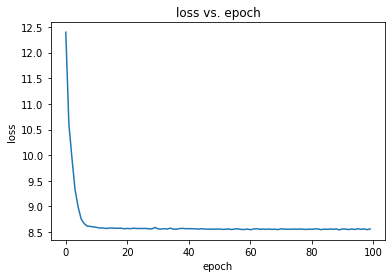

In [150]:
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,chain_1,bijectors=bijectors,batch_size=5000,n_epochs=100)

Removed no burn in


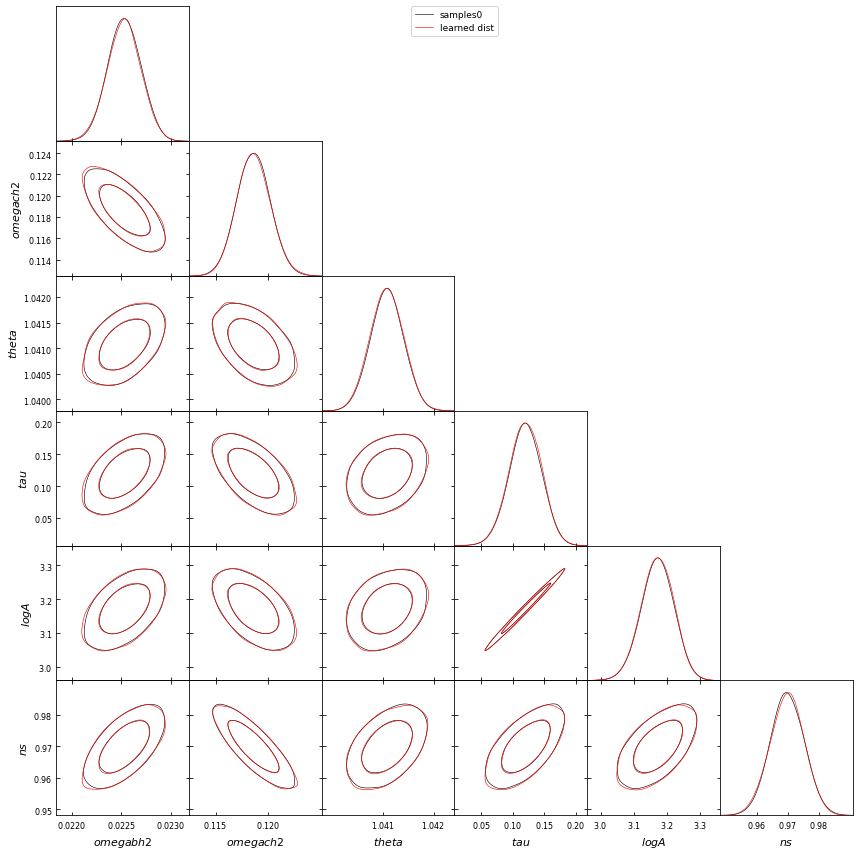

In [151]:
# Plot learned distribution
_samples = np.array(trained_dist.sample(10000))
_samples = bijector.forward(_samples)

sample = MCSamples(samples=_samples.numpy(), names=planck_names[:6],label='learned dist')
g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([chain_1,sample],
                params=planck_names[:6],
                filled=False,
                markers={_p:0 for _p in planck_names[:6]})

In [162]:
### LSST MCMC Functions
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.001, 0.99]])

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:29]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    return lnprior(theta) + ln_lkl(theta) + planck_ln_lkl(theta)

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:29]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

In [168]:
### Planck MCMC functions
#
# from LSST emulator for index reference
# names = ['logA', 'ns', 'H0', 'omegab', 'omegac']

def planck_ln_lkl(theta):
    pspec = theta[0:2]
    densities = theta[3:5]
    planck2 = theta[29:31]
    #planck2 = theta[5:7]
    theta_planck = [densities[0],densities[1],planck2[0],planck2[1],pspec[0],pspec[1]]
    lkl = trained_dist.log_prob(theta_planck).numpy()
    return lkl

In [174]:
# open the emulator
# Get the LSST covariance and fid data
path = '/home/grads/data/evan/tension_calibration/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

configfile = 'configs/nn_emu.yaml'
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

savedir = 'output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load('model/nn_emu/model')
# ======================================================

data_model.emu = emu

bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

N_MCMC        = 5000
N_WALKERS     = 120
NDIM_SAMPLING = 31

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1,0.01,0.01]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [175]:
start_time = time.time()
#with Pool(10) as pool:
emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob)#, pool=pool)
emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

  5%|████▍                                                                              | 271/5000 [1:42:41<28:55:40, 22.02s/it]Traceback (most recent call last):
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_3588439/1301226312.py", line 82, in lnprob
    return lnprior(theta) + ln_lkl(theta) + planck_ln_lkl(theta)
  File "/tmp/ipykernel_3588439/1462940827.py", line 12, in planck_ln_lkl
    lkl = trained_dist.log_prob(theta_planck).numpy()
  File "/home/grads/.conda/envs/emu/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1315, in log_prob
    return self._call_log_prob(value, name, **kwargs)
  File "/home/grads/.conda/envs/emu/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py", line 1297, in _call_log_prob
    return self._log_prob(value, **kwargs)
  File "/home/grads/.conda/envs/e

emcee: Exception while calling your likelihood function:
  params: [ 3.00749479e+00  9.73940776e-01  6.85569002e+01  2.45176903e-02
  1.23884027e-01  1.22996855e-02  5.29085051e-03  3.43080130e-03
 -2.78284091e-03 -4.77123647e-03  4.54882565e-01  8.54006383e-02
 -1.49049120e-03  1.05458705e-02 -4.45956840e-03  3.27112780e-03
  1.21635168e-02  1.25118994e+00  1.52026240e+00  1.61108837e+00
  1.65858342e+00  1.81418948e+00  7.76174252e-04 -1.80056055e-02
  3.84129974e-03  1.80122119e-02  6.41262451e-03 -2.86375424e-01
  9.25519685e-01  1.05076132e+00  1.14128687e-01]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 